In [90]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterGrid
from metrics import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
pd.options.mode.chained_assignment = None  # Suppress the warning

In [58]:
def split_by_session(data, test_size=0.2, random_state=42):
    # Get unique sessions
    unique_sessions = data['impression_id'].unique()

    # Split sessions into train and test
    train_sessions, test_sessions = train_test_split(unique_sessions,
                                                    test_size=test_size,
                                                    random_state=random_state)

    # Create train and test sets
    train_data = data[data['impression_id'].isin(train_sessions)]
    test_data = data[data['impression_id'].isin(test_sessions)]

    return train_data, test_data

In [78]:
df = pd.read_parquet("train_dataset_ebnerd_small.parquet")


train_data, validation_data = split_by_session(df, test_size = 0.2)


test_data = pd.read_parquet("test_dataset_ebnerd_small.parquet")
print(len(train_data), len(validation_data), len(test_data))


1507242 375276 703229


In [ ]:
import pandas as pd
import xgboost as xgb

# Assuming train_data and test_data are your DataFrames
target = ["clicked"]
ids = ["impression_id", "session_id", "article_id", "user_id"]
excluded_columns = target + ids

# Step 1: Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
feature_list = [col for col in train_data.columns if col not in excluded_columns]

# Step 2: Combine feature_list with categorical_columns to ensure we're encoding them correctly
feature_list = list(set(feature_list + categorical_columns))
print("Features used for modeling:", feature_list)

# Prepare training data
X_train = pd.get_dummies(train_data[feature_list], drop_first=True)
y_train = train_data['clicked'].values
group_train = train_data.groupby('impression_id').size().to_list()
dtrain = xgb.DMatrix(X_train, label=y_train, group=group_train)

# Prepare validation data
X_val = pd.get_dummies(validation_data[feature_list], drop_first=True)
# Align columns with training data
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)  # Ensure the same columns as X_train
y_val = validation_data['clicked'].values
group_val = validation_data.groupby('impression_id').size().to_list()
dval = xgb.DMatrix(X_val, label=y_val, group=group_val)

#####
# Test data
#####
# Load test data
X_test = pd.get_dummies(test_data[feature_list], drop_first=True)
# Align columns with training data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # Ensure the same columns as X_train
y_test = test_data['clicked'].values

# Create the group list for test data
group_test = test_data.groupby('impression_id').size().to_list()

# Convert to DMatrix for XGBoost
dtest = xgb.DMatrix(X_test, label=y_test, group=group_test)


Features used for modeling: ['user_average_read_time', 'user_interaction_score', 'origin_sentiment_score', 'origin_scroll_percentage', 'time_of_day', 'user_mood', 'origin_sentiment_label', 'user_article_same_mood', 'time_diff_origin_and_inview', 'coming_from_home_page', 'premium', 'user_average_scroll_percentage', 'cluster', 'origin_read_time', 'is_subscriber', 'is_sso_user', 'user_article_favorite', 'device_type', 'user_impression_frequency', 'sentiment_score', 'sentiment_label', 'user_article_least_favorite', 'time_diff_origin_and_impression']


In [61]:
from sklearn.model_selection import ParameterGrid
import xgboost as xgb


# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Tracking the best model and score
best_score = -float('inf')
best_params = None

stop_after = 3
iterations = 0
for params in tqdm(ParameterGrid(param_grid)):
    iterations +=1
    # Initialize the model with current parameters
    model = xgb.XGBRanker(objective='rank:pairwise', eval_metric='ndcg', **params)

    # Train on the training data, evaluate on the validation set
    model.fit(
        X_train,
        y_train,
        group=group_train,
        eval_set=[(X_val, y_val)],
        eval_group=[group_val],
        verbose=False
    )

    # Predict and evaluate NDCG on the validation set
    y_pred_valid = model.predict(X_val)
    validation_data.loc[:, 'predicted_score'] = y_pred_valid
    ndcg_score = calculate_ndcg(validation_data, k=10)  # Custom function for NDCG

    if ndcg_score > best_score:
        best_score = ndcg_score
        best_params = params

    if iterations > stop_after:
        print("testing done")
        break


# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Validation NDCG@10:", best_score)


  2%|▏         | 3/144 [00:35<27:44, 11.81s/it]

testing done
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best Validation NDCG@10: 0.8630152897016883


In [81]:
# Step 1: Combine train and validation data
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val])
group_combined = group_train + group_val  # Concatenate group lists

# Step 2: Train final model with best hyperparameters on combined data
final_model = xgb.XGBRanker(objective='rank:pairwise', eval_metric='ndcg', **best_params)

final_model.fit(
    X_combined,
    y_combined,
    group=group_combined,
    verbose=True
)

# Step 3: Generate predictions on test data
y_pred_test = final_model.predict(X_test)

# Optionally add predictions to test DataFrame
test_data['predicted_score'] = y_pred_test

# Output the predictions
print(test_data[['impression_id', 'predicted_score']])


        impression_id  predicted_score
0              149474        -0.005512
1              149474        -0.060820
2              149474         0.109328
3              149474         0.121345
4              149474        -0.099851
...               ...              ...
703224      579756177         0.024006
703225      579756177         0.099146
703226      579756177         0.022395
703227      579756177         0.016036
703228      579756177         0.084061

[703229 rows x 2 columns]


In [85]:
# Sort articles by predicted score within each session
test_data = test_data.sort_values(by=['impression_id', 'predicted_score'], ascending=[True, False])

# Display the ranked articles
print(test_data[['impression_id', 'article_id','clicked', 'predicted_score']])

        impression_id  article_id  clicked  predicted_score
3              149474     9778657     True         0.121345
2              149474     9778669    False         0.109328
0              149474     9778623    False        -0.005512
1              149474     9778682    False        -0.060820
4              149474     9778736    False        -0.099851
...               ...         ...      ...              ...
703226      579756177     9778219    False         0.022395
703227      579756177     9778842    False         0.016036
703222      579756177     9778722    False         0.004525
703221      579756177     9778917    False        -0.004344
703223      579756177     9220931    False        -0.288815

[703229 rows x 4 columns]


In [ ]:


results = test_data.groupby('impression_id', group_keys=False).apply(lambda x: pd.Series({
    'AUC': calculate_auc(x),
    'MRR': calculate_mrr(x),
    'NDCG@5': calculate_ndcg(x, 5),
    'NDCG@10': calculate_ndcg(x, 10)
}))
# WHY IS THIS SO SLOW?
print(results) 


/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_6840/1710653369.py:23: RuntimeWarning: divide by zero encountered in divide
  return np.sum(scores / discounts)
/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_6840/1710653369.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return dcg_k / idcg_k if idcg_k > 0 else 0
/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_6840/1710653369.py:23: RuntimeWarning: invalid value encountered in divide
  return np.sum(scores / discounts)
/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_6840/1710653369.py:23: RuntimeWarning: divide by zero encountered in divide
  return np.sum(scores / discounts)
/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_6840/1710653369.py:23: RuntimeWarning: invalid value encountered in divide
  return np.sum(scores / discounts)
/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_6840/1710653369.py:23: RuntimeWarning: divide by zero encountered in divi

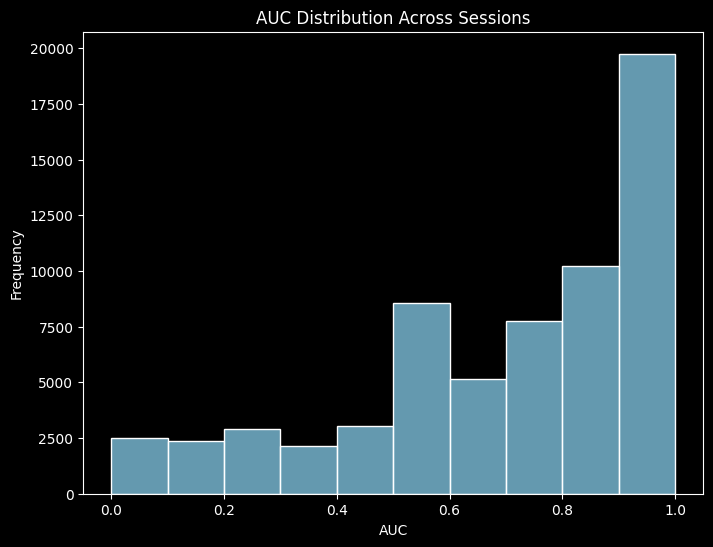

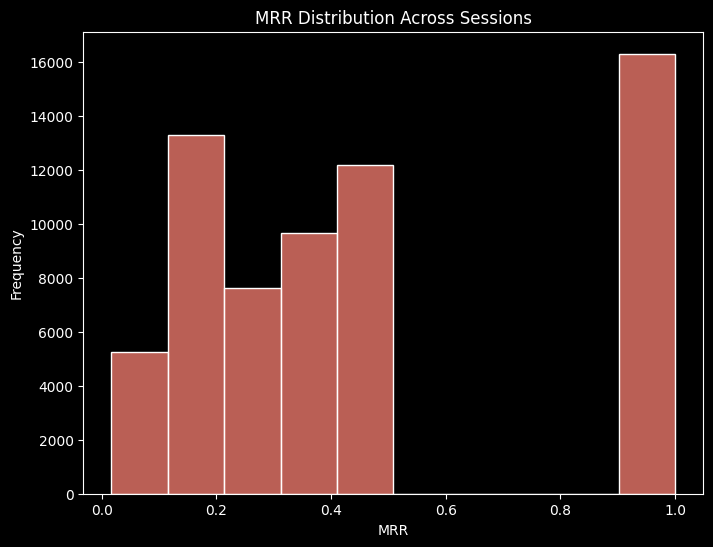

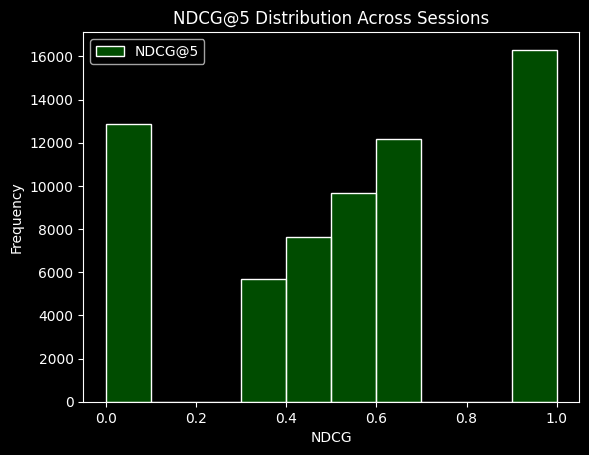

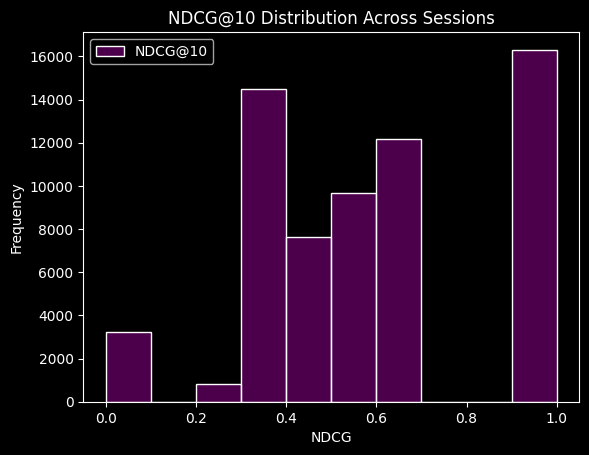

In [65]:
# Plot 1: Precision-Recall Curve for a sample session
def plot_precision_recall(data):
    precision, recall, _ = precision_recall_curve(data['clicked'], data['predicted_score'])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Plot 2: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=False, color="skyblue", bins=10)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()

# Plot 3: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=False, color="salmon", bins=10)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.show()

# Plot 4: NDCG@5 and NDCG@10 Distributions
sns.histplot(results['NDCG@5'], kde=False, color="green", label="NDCG@5", bins=10, alpha=0.6)
plt.title("NDCG@5 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


sns.histplot(results['NDCG@10'], kde=False, color="purple", label="NDCG@10", bins=10, alpha=0.6)
plt.title("NDCG@10 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()
